# Getting started with the swift python package

## About this document

This is a minimal but realistic simulation workflow for swift. It was ported from an original [vignette](https://github.com/csiro-hydroinformatics/streamflow-forecasting-tools-onboard/blob/master/doc/vignettes/getting_started/getting_started.md) in the R package `swift`. The python package [`swift2`](https://csiro-hydroinformatics.github.io/swift-py-doc/) is, as of August 2023, at least at feature parity with the long established R package. 

This is the introduction 'notebook' to a python package for interacting with SWIFT. It shows one of the most basic usage, running a single model simulation. While basic, it is realistic and uses data from a study catchment.

In [1]:
from swift2.doc_helper import pkg_versions_info

print(pkg_versions_info("This document was generated from a jupyter notebook"))

This document was generated from a jupyter notebook on 2025-05-16 14:18:01.960931
    swift2 2.5.1
    uchronia 2.6.2


## Prerequisites

This notebook requires a working Python environment, e.g. a conda environment. See the [Streamflow Forecasting](https://csiro-hydroinformatics.github.io/streamflow-forecasting-tools-onboard/) landing page for information about installing the software.

## Imports


In [2]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Finally we import some visualisation facilities

In [3]:
import seaborn as sns
import xarray as xr

Some dependencies of **swift2**, namely **cinterop**, offer generic functions for time series manipulations. While these could be imported via **swift2** as well, let's be explicit for now:

In [4]:
from cinterop.timeseries import (
    TIME_DIMNAME,
    as_timestamp,
    pd_series_to_xr_series,
    slice_xr_time_series,
    xr_ts_end,
    xr_ts_start,
)
from swift2.doc_helper import get_free_params, sample_series
from swift2.parameteriser import (
    create_parameter_sampler,
    create_parameteriser,
    create_sce_termination_wila,
    get_default_sce_parameters,
)
from swift2.simulation import create_subarea_simulation

In [5]:
from swift2.system import runoff_model_ids, runoff_model_var_ids

We import the main functions upfront from the package submodules. In practice this is something you may need to do only on an as needed basis of course. Jupyter notebooks can show dynanically submodules and functions listed, along with some documentation. A searchable technical documentation for the package is available from [Python swift2 documentation](https://csiro-hydroinformatics.github.io/swift-py-doc). 

In [6]:
from swift2.utils import mk_full_data_id, paste_2, vpaste

In [7]:
%matplotlib inline

## Lumped catchment data, daily data

The package contains some sample data for a few Australian catchments. Note that these sample data are for documentation only and not to be used for real world applications.  

**swift** now has some functions to create a single subarea simulation for testing purposes, including the function `create_subarea_simulation`. While is it perfectly possible to manually build your own model simulation from scratch, for the sake of getting started quickly let's use pre-defined functions to get a model simulation ready to run. The parameters of the function should be fairly self-explanatory. But in general you can see function documentation with commands appended with the `?` string, e.g. `create_subarea_simulation?`. You can also browse the [Python swift2 documentation](https://csiro-hydroinformatics.github.io/swift-py-doc).

In [8]:
create_subarea_simulation?

In [9]:
ms = create_subarea_simulation(data_id='MMH', simul_start='1990-01-01', simul_end='2005-12-31', 
    model_id='GR4J', tstep='daily', varname_rain='P', varname_pet='E')

In [10]:
ms

Simulation wrapper for a CFFI pointer handle to a native pointer of type id "MODEL_SIMULATION_PTR"

In [11]:
type(ms)

swift2.classes.Simulation

The python object `ms` may appear unusual to most users. This is basically a handle to the SWIFT simulation object written in C++. The model core is native, but wrapped by a "pythonic" `Simulation` object. The low-level interaction between python and the C API is handled by "glue code" and users will rarely if ever need to use the low-level API.

The `Simulation` object has python methods to interact with it, for instance:

In [12]:
ms.describe?

In [13]:
ms.describe()

{'subareas': {'Subarea': 'Subarea'}, 'nodes': {}, 'links': {}}

Because we got a preconfigured, sample simulation, it is ready to execute, which means it already has some input data defined (a site with a codename 'MMH'). The `SWIFT` system uses the terms `playing from` and `recording to` time series, using an old style audio tape system as a metaphor. We can inspect the simulation for instance using `get_played_varnames` to check which state variable has an input time series:

In [14]:
ms.get_played_varnames()

['subarea.Subarea.E', 'subarea.Subarea.P']

### Time series data representation

Let us have a look at these input time series to the simulation:

In [15]:
tts = ms.get_played()
tts

<xarray.DataArray (variable_identifiers: 2, ensemble: 1, time: 5844)> Size: 94kB
array([[[5.5422, 5.5522, 5.5622, ..., 6.0744, 6.0735, 6.0725]],

       [[0.    , 0.    , 0.    , ..., 2.1569, 0.    , 0.    ]]],
      shape=(2, 1, 5844))
Coordinates:
  * ensemble              (ensemble) int64 8B 0
  * time                  (time) datetime64[ns] 47kB 1990-01-01 ... 2005-12-31
  * variable_identifiers  (variable_identifiers) object 16B 'subarea.Subarea....

The C++ core has its own internal representation of time series. The Python package `swift2` uses generally [`xarray`](https://docs.xarray.dev/en/stable/) to represent time series, as it is particularly suited to handle ensemble of time series of dimensionality more than 2. The ensemble dimension is thus present by default in the returned array, even when there is only one realisation. This can be removed with the [`squeeze`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.squeeze.html#xarray.DataArray.squeeze) method of xarray. 

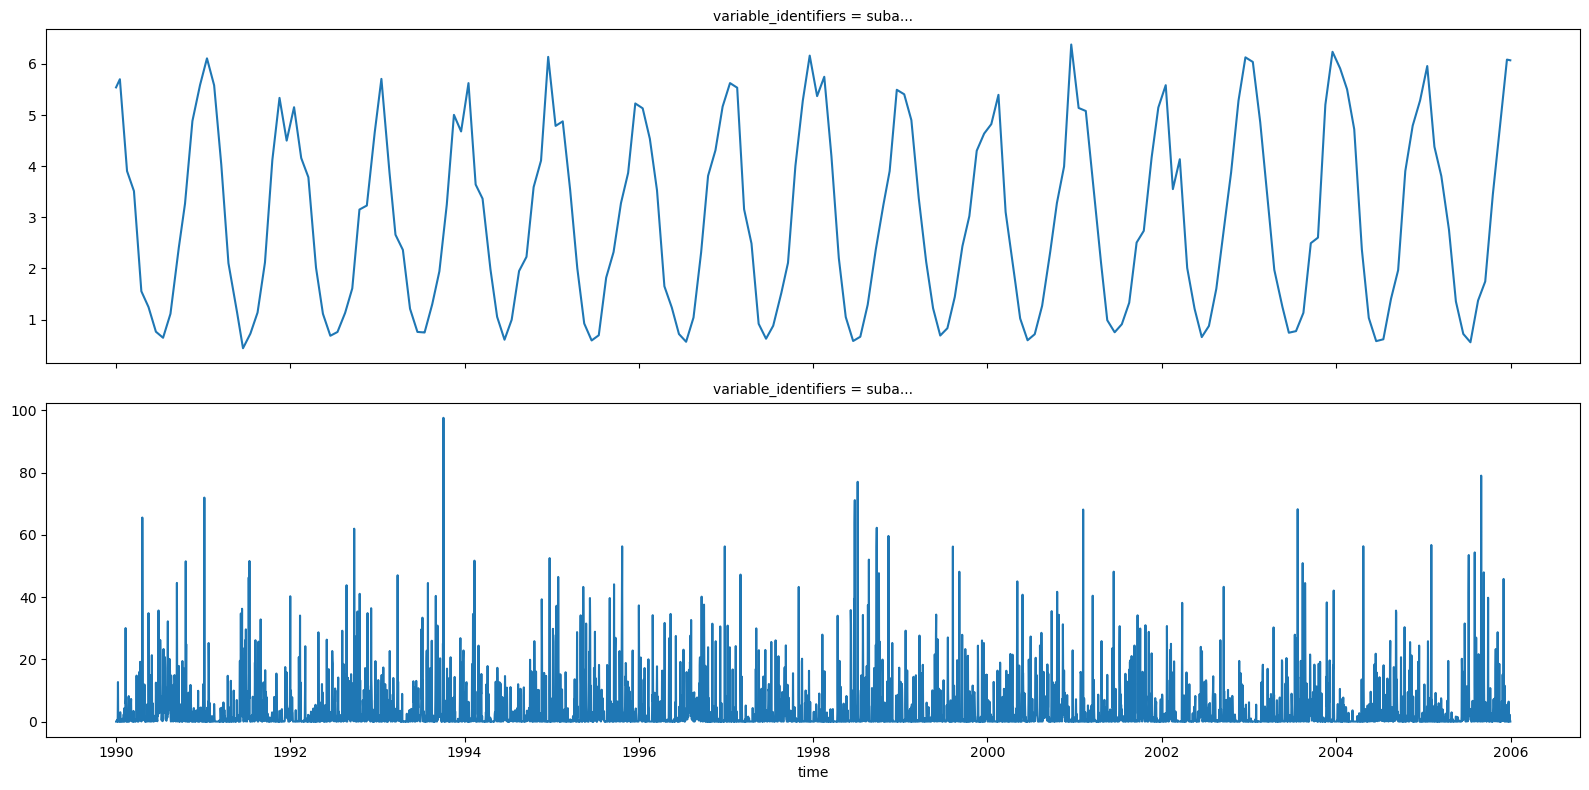

In [16]:
tts = tts.squeeze(drop=True)
g = tts.plot.line(add_legend=True, figsize=(16,8), col="variable_identifiers", col_wrap=1, sharey=False)
g;


Many `swift2` python functions will however also accept [pandas](https://pandas.pydata.org/docs/) `DataFrame` or `Series` as input for time series when it makes sense to accept such time series representations.

In [17]:
ms.play_input?

We can check with the `get_recorded_varnames` method that simulation object as not been "told" to record an output time series yet. 

In [18]:
ms.get_recorded_varnames()

[]

SWIFT is designed to record model variables on demand in a highly flexible manner. First, we can query the system to find out known rainfall-runoff models, and the model variable names that we can record.

In [19]:
runoff_model_ids()

['NetRainfall',
 'GR2M_MOD',
 'GR4J',
 'GR4J_SG',
 'GR5H',
 'GR6J',
 'GR5J',
 'PDM',
 'AWBM',
 'SACSMA',
 'SACSMA_NSW',
 'IHACRES',
 'constant_outflow',
 'external',
 'WAPABA',
 'GRKAL',
 'SimHyd',
 'HBV']

The GR4J model has the following states that can be "listened to" and "recorded" on demand over a simulation.

In [20]:
gr4j_model_vars = runoff_model_var_ids('GR4J')
print(gr4j_model_vars)

['P', 'E', 'En', 'LAI', 'runoff', 'S', 'R', 'TWS', 'Eactual', 'Ps', 'Es', 'Pr', 'ech1', 'ech2', 'Perc', 'alpha', 'k', 'x1', 'x2', 'x3', 'x4', 'UHExponent', 'PercFactor']


These are the variable names for a single GR4J model instance; since SWIFT is for semi-distributed models, we need to use a hierarchical naming scheme to uniquely identify model variables (even when in this case we do have only one subarea). Using unique keys allow to inspect the model states in great details if needed.

In [21]:
ms.get_subarea_ids()
ms.get_state_value('subarea.Subarea.x4')

{'subarea.Subarea.x4': 0.5}


Let's record to time series all the storage and flux states of GR4J (no need to record model parameters which will be flat lines here). We can use the utility function [`mk_full_data_id`](https://csiro-hydroinformatics.github.io/swift-py-doc/code-reference/?h=mk_full_data_id#swift2.utils.mk_full_data_id) for conciseness to vectorise the handling of multiple state identifiers.


In [22]:
to_record = ['runoff', 'S', 'R', 'Ps', 'Es', 'Pr', 'ech1', 'ech2', 'Perc']
ids = mk_full_data_id('subarea', 'Subarea', to_record)

In [23]:
ms.record_state(ids)
ms.get_recorded_varnames()

['subarea.Subarea.Es',
 'subarea.Subarea.Perc',
 'subarea.Subarea.Pr',
 'subarea.Subarea.Ps',
 'subarea.Subarea.R',
 'subarea.Subarea.S',
 'subarea.Subarea.ech1',
 'subarea.Subarea.ech2',
 'subarea.Subarea.runoff']

### Model execution

`ms` was configured to record model outputs, now we can execute the simulation, with its parameters set to whatever defaults it has. Note that `ms` also has a `check_simulation` method that can provide information about  obvious configuration issues when execution fails. Typically inconstent start and end dates between simulation and input time series. In this case, nothing is reported in this simple and preconfigured case.

In [24]:
ms.check_simulation()

{'errors': []}

In [25]:
ms.exec_simulation()

### Model outputs

In [26]:
var_series = ms.get_recorded()

We have a 3 dimensional data array, with 9 identifiers for state variables:

In [27]:
var_series.dims, var_series.shape

(('variable_identifiers', 'ensemble', 'time'), (9, 1, 5844))

In [28]:
var_coords = var_series.coords['variable_identifiers'].values
var_coords

array(['subarea.Subarea.Es', 'subarea.Subarea.Perc', 'subarea.Subarea.Pr',
       'subarea.Subarea.Ps', 'subarea.Subarea.R', 'subarea.Subarea.S',
       'subarea.Subarea.ech1', 'subarea.Subarea.ech2',
       'subarea.Subarea.runoff'], dtype=object)

The variable identifiers are fully qualified, which is fine and certainly make a lot of sense for semi-distributed catchments. But to visualise these for a single subarea we shall override with short model names:

In [29]:
var_series.coords['variable_identifiers'] = to_record

### Visualising model states

Let's look at a shorter period of the output. We define a couple of functions to slice and plot the last three years of the time series, for clarity.

In [30]:
def last_three_years(tts:xr.DataArray):
    start=tts.coords[TIME_DIMNAME].values[-(365*3)]
    end=tts.coords[TIME_DIMNAME].values[-1]
    return slice_xr_time_series(tts, start, end)

def plot_obs_vs_calc(obs, calc, ylab="runoff (mm)"):
    import uchronia.utils as uu
    obs = last_three_years(obs)
    calc = last_three_years(calc)
    both = uu.xr_concat([obs,calc], ['observed','calculated'], 'type')
    both.plot.line(add_legend=True, figsize=(9,4), hue="type")
    plt.ylabel(ylab)

In [31]:
s = last_three_years(var_series)
# , main = 'Default GR4J output on MMH data')

In [32]:
s = s.squeeze(drop=True)

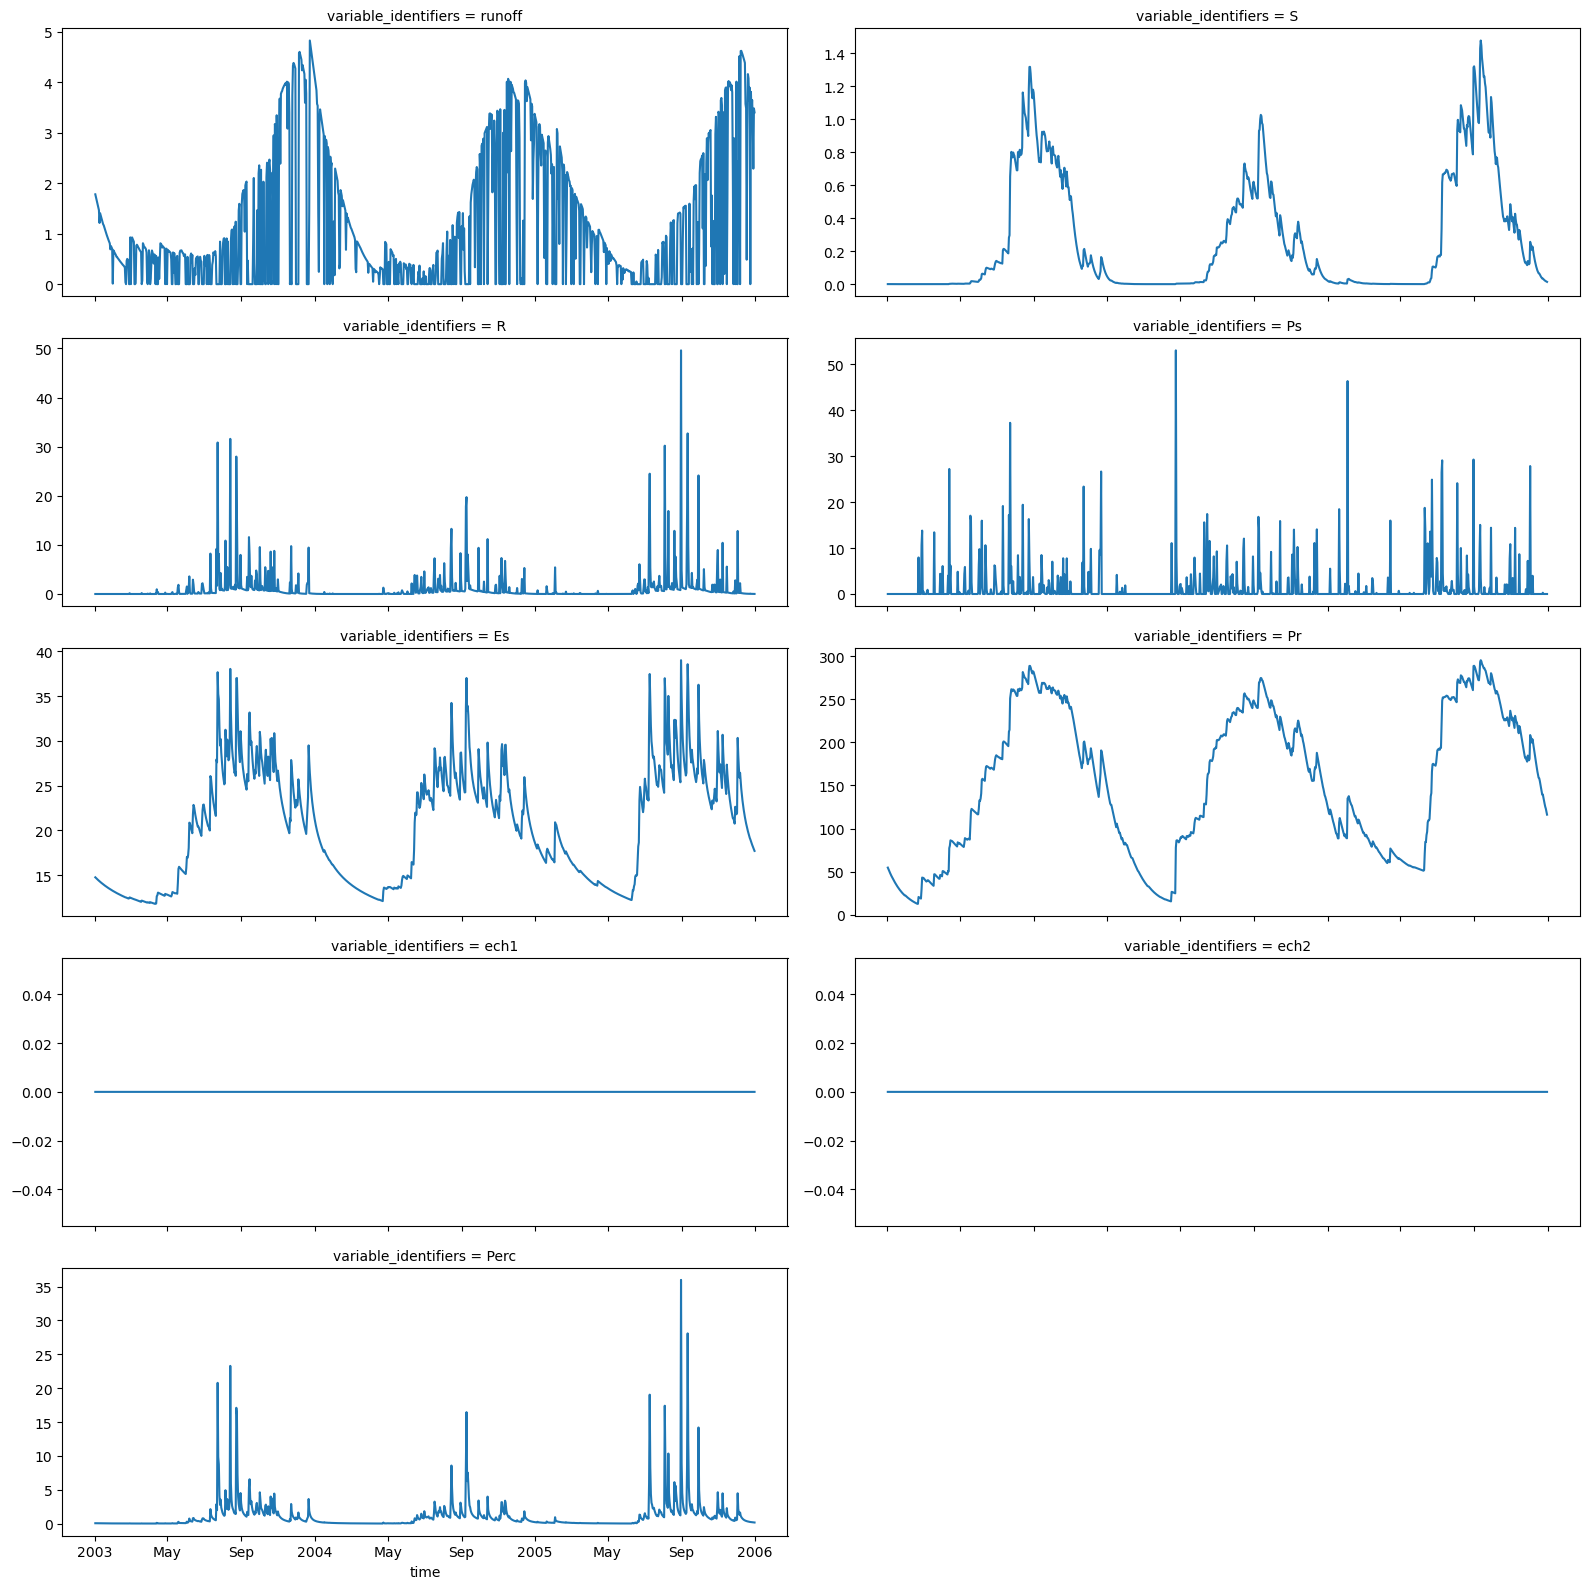

In [33]:
g = s.plot.line(add_legend=True, figsize=(16,16), col="variable_identifiers", col_wrap=2, sharey=False)


## Exploring the model interactively

### Assessing a change in the input series

As mentioned earlier, it is change to define the model simulation definition directly and interactively. The following shows how a to assign another input time series. We use a somewhat contrived example of a scaled up precipitation input series, to see what is the effect on the runoff.

In [34]:
precip_id = 'subarea.Subarea.P'
runoff_id = 'subarea.Subarea.runoff'
precip = ms.get_played(precip_id)
baseline_runoff = ms.get_recorded(runoff_id)

Because we are about to work on a scenario, rather than modifying `ms` we are going to keep it as a clean baseline, and create a full "clone" of the catchment model. This is an understated feature of `swift2`, but a cornerstone of proper scenario comparison (and help limit modelling mistakes)

In [35]:
ms_wetter = ms.clone()

In [36]:
precip_scaled = precip * 1.1
precip_scaled = precip_scaled.squeeze(drop=True)
ms_wetter.play_input(precip_scaled, precip_id)
ms_wetter.exec_simulation()
runoff_diff = ms_wetter.get_recorded(runoff_id) - baseline_runoff

In [37]:
runoff_diff = runoff_diff.squeeze(drop=True)

The additional runoff depth we get with a rainfall scaled up by 10 percent is:

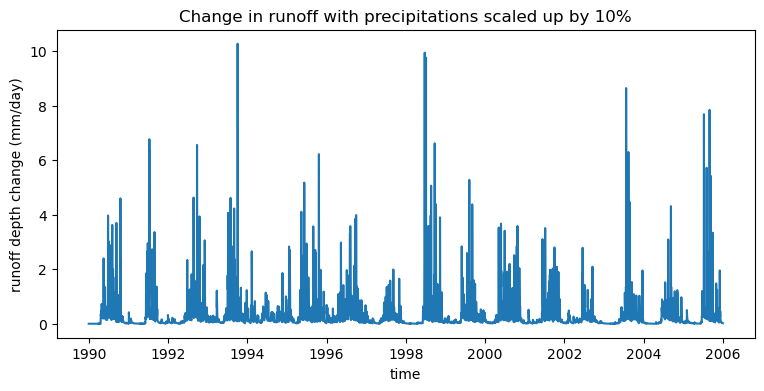

In [38]:
runoff_diff.plot(figsize=(9,4))
plt.title('Change in runoff with precipitations scaled up by 10%')
plt.ylabel('runoff depth change (mm/day)');

### Assessing the impact of a change in one model parameter


In [39]:
x4_id = 'subarea.Subarea.x4'
x4 = ms.get_state_value(x4_id)
x4

{'subarea.Subarea.x4': 0.5}

The returned value for $x_4$ is in a dictionary, because `get_state_value` is vectorised and can retrieve several state values at the same time. `set_state_value` on the other hand accepts multiple types of inputs including scalars for convenience:

In [40]:
x4_inital = x4[x4_id]
# Again, keep the baseline clean and work on a copy
ms_x4 = ms.clone()

ms_x4.set_state_value(x4_id, x4_inital*1.1)
ms_x4.exec_simulation()
runoff_diff = ms_x4.get_recorded(runoff_id) - baseline_runoff

One effect of $x_4$ is on the lagging effect, so the difference in runoff should be overall near zero, but with local variations:  

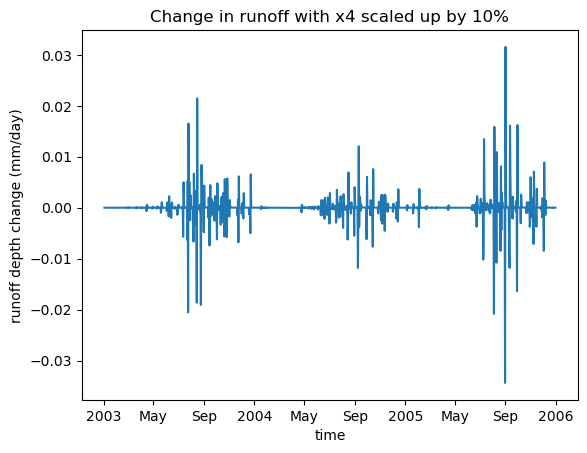

In [41]:
runoff_diff = runoff_diff.squeeze(drop=True)
blah = last_three_years(runoff_diff).plot.line()
plt.title('Change in runoff with x4 scaled up by 10%')
plt.ylabel('runoff depth change (mm/day)');


## Calibration

Let's now set up a calibration against the observed runoff depth for this data 'MMH', included as sample data in the package, and view it along the current default model runoff output.

In [42]:
obs_runoff = sample_series('MMH', 'flow') #actually, runoff depth

Negative data in the observed streamflow is a code for missing data. It is better to use `np.nan` in Python for this.

In [43]:
obs_runoff[obs_runoff < -1] = np.nan
obs_runoff = pd_series_to_xr_series(obs_runoff)

Let's view the default modelled output from **GR4J**, overlayed with the observation

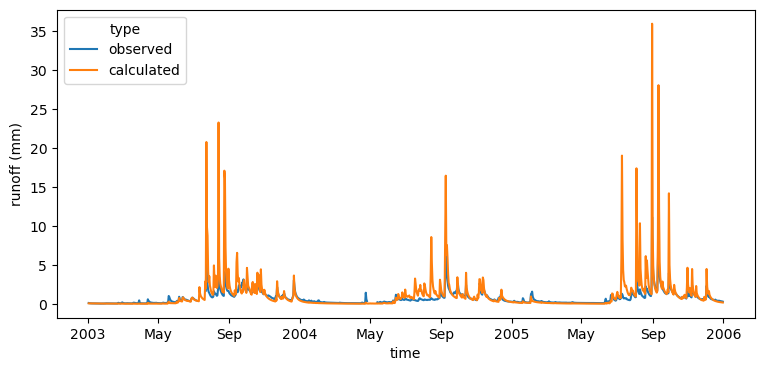

In [44]:
plot_obs_vs_calc(obs_runoff, baseline_runoff.squeeze(drop=True));

### Defining the calibration

Before we go ahead in setting up this calibration, it is worth outlining key aspects of software architecture in `swift2` and its [metaheuristics optimisation library, "wila"](https://github.com/csiro-hydroinformatics/wila) upfront.

At a high level a calibration process conceptually needs:

* the specification of a feasible parameter space $X = x_1, x_2, ..., x_n$, typically with feasible intervals for each $x_i$
* an objective evaluation $Obj(X)$
* and an optimisation algorithm that uses $Obj$ and evaluates it on parameter values $X_p$ sampled from $X$

Formulating a calibration in `swift2` follows this pattern. There is usually no need to explicitely handle the hydrological model, which is hidden behind $Obj$, and for some reasons this can be an unfamiliar viewpoint for many hydrologist.

Readers interesting in modelling and optimisation framework design and implementation can read [Talbi, El-Ghazali. Metaheuristics: from design to implementation. John Wiley & Sons, 2009.](https://dl.acm.org/doi/abs/10.5555/1718024) for a comprehensive overview.

Now let us see what these are in practice. 

**Note**: There are several time stamp representations in the Python ecosystem. A dependency package of the `swift2` package , **cinterop**, has a [time series module](https://cinterop.readthedocs.io/en/latest/timeseries-module/) with date-time and time series related utilities, such as `xr_ts_start`, `as_timestamp` to reduce the tedium of date-time handling. You may also already be using third-party utilities as well. 

#### Objective

Part of the information for the objective is over which time span we calculate the goodness of fit, usually different from the simulation length to leave period for a model warmup

In [45]:
s = xr_ts_start(obs_runoff)
# Warmup:
w = as_timestamp(s) + pd.DateOffset(years=2)
e = xr_ts_end(obs_runoff)
ms.set_simulation_span(s, e)

We now have all the information needed to create a calibration objective using for instance the Nash-Sutcliffe Efficiency 

In [46]:
objective = ms.create_objective(runoff_id, obs_runoff, 'NSE', w, e)

The variable `objective` now references an objective evaluator.

In [47]:
type(objective), objective

(swift2.classes.ObjectiveEvaluator,
 CFFI pointer handle to a native pointer of type id "OBJECTIVE_EVALUATOR_WILA_PTR")

An objective evaluator evaluates one or more goodness of fit (a.k.a. "scores") via the method `objective.get_score`. We need to provide a set of model parameters to evaluate the resulting scores. The utility function `get_free_params` provides a template for some models including **GR4J**, in the form of a pandas DataFrame

#### Feasible parameter space


In [48]:
pspec_gr4j = get_free_params('GR4J')
pspec_gr4j

,Name,Value,Min,Max
0,x1,650.488000,1.0,3000.0
1,x2,-0.280648,-27.0,27.0
2,x3,7.891230,1.0,660.0
3,x4,18.917200,1.0,240.0


We can set some values and min/max bounds in this data frame. The min/max bounds are important for the upcoming calibration process.

In [49]:
pspec_gr4j.Value = [542.1981111,  -0.4127542,   7.7403390 ,  1.2388548]
pspec_gr4j.Min = [1,-30, 1,1]
pspec_gr4j.Max = [1000.0, 30, 1000, 240]

In [50]:
pspec_gr4j

,Name,Value,Min,Max
0,x1,542.198111,1,1000.0
1,x2,-0.412754,-30,30.0
2,x3,7.740339,1,1000.0
3,x4,1.238855,1,240.0


Our model states have the prefix 'subarea.Subarea.', so we need to use this prefix in our data frame of parameters as well.

In [51]:
pspec_gr4j.Name = vpaste('subarea.Subarea.', pspec_gr4j.Name)

We can now create a parameteriser. It can be converted back to a data frame to check its content.

**Note**: we will be using the untransformed parameters for calibration for the sake of simplicity in this introductory material. In practice we should use some transformations to facilitate the calibration, and there are many features in **swift2** to do so.

In [52]:
p = create_parameteriser('Generic', pspec_gr4j)
p.as_dataframe()

,Name,Value,Min,Max
0,subarea.Subarea.x1,542.198111,1.0,1000.0
1,subarea.Subarea.x2,-0.412754,-30.0,30.0
2,subarea.Subarea.x3,7.740339,1.0,1000.0
3,subarea.Subarea.x4,1.238855,1.0,240.0


Now let us check that we can indeed evaluate the goodness of fit for this parameteriser `p` using the `objective`: 

In [53]:
score = objective.get_score(p)
score

{'scores': {'NSE': -2.3381787784819057},
 'sysconfig':                  Name       Value   Min     Max
 0  subarea.Subarea.x1  542.198111   1.0  1000.0
 1  subarea.Subarea.x2   -0.412754 -30.0    30.0
 2  subarea.Subarea.x3    7.740339   1.0  1000.0
 3  subarea.Subarea.x4    1.238855   1.0   240.0}

Our calibration objective calculator is structurally valid.

#### Optimiser

To create an optimiser, we need to specify a termination criterion. There are several options available to control when an optimisation process will finish in a calibration. One of them uses the standard deviation of parameter values for population based algorithms such as the shuffled complex evolution algorithm (SCE). We can specify that the optimisation has converged once the standard deviation of each parameter (x1, x2, etc. for GR4J) is within 

In [54]:
term = create_sce_termination_wila('relative standard deviation', ['0.002','0.0167'])

In [55]:
sce_params = get_default_sce_parameters()
urs = create_parameter_sampler(0, p, 'urs')
optimiser = objective.create_sce_optim_swift(term, sce_params, urs)

In [56]:
optimiser.set_calibration_logger('')

In [57]:
%%time
calib_results = optimiser.execute_optimisation()

CPU times: user 20.5 s, sys: 23.5 ms, total: 20.5 s
Wall time: 4.08 s


**swift** uses optimization tools that will parallelize model simulation runs if possible (i.e. if supported by the model). This may not be noticeable in this instance, but is important to scale up to larger catchment models. 

## Assessing the optimisation

There are facilities in the package to extract, exploit and visualise the optimisation log information.


In [58]:
opt_log = optimiser.extract_optimisation_log(fitness_name = "NSE")

In [59]:
opt_log.data.head()

,Category,CurrentShuffle,Message,NSE,subarea.Subarea.x1,subarea.Subarea.x2,subarea.Subarea.x3,subarea.Subarea.x4,PointNumber
0,Initial Population,,Initial Population,-1339.285380,947.690750,23.005202,62.217181,161.886443,1
1,Initial Population,,Initial Population,-0.890844,174.551633,-7.280393,710.469274,96.390541,2
2,Initial Population,,Initial Population,-0.327150,214.709001,-7.069954,124.638641,18.990489,3
3,Initial Population,,Initial Population,-2.367463,724.720289,6.659042,930.609993,207.726829,4
4,Initial Population,,Initial Population,-913.046415,874.130073,28.643820,126.360349,83.693269,5


In [60]:
opt_log.data.tail()

,Category,CurrentShuffle,Message,NSE,subarea.Subarea.x1,subarea.Subarea.x2,subarea.Subarea.x3,subarea.Subarea.x4,PointNumber
13967,Shuffling No 28,,Shuffling No 28,0.768667,999.096491,-5.620413,91.829530,1.000574,13968
13968,Shuffling No 28,,Shuffling No 28,0.768742,996.688456,-5.679336,93.670035,1.000339,13969
13969,Shuffling No 28,,Shuffling No 28,0.768590,995.813747,-5.731252,95.427583,1.000443,13970
13970,Shuffling No 28,,Shuffling No 28,0.768553,994.549300,-5.677011,96.570436,1.000202,13971
13971,Shuffling No 28,,Best point in shuffle,0.768844,997.616573,-5.649821,92.890522,1.000003,13972


Let's subset the data points to keep a subset, the points from the initial population and SCE geometric transformations (reflection, contraction, addition). We can use a regular expression pattern to do so. `MhData` is a glorified data frame, but its methods are handy to reduce tedium.

In [61]:
geom_ops = opt_log.subset_by_message(pattern= 'Initial.*|Reflec.*|Contrac.*|Add.*') # same as default argument, but to be explicit

Let us also rename the column names without the fully qualified prefix

In [62]:
p_var_ids = ['x1','x2','x3','x4']
remap = {f'subarea.Subarea.{name}': name for name in p_var_ids}
geom_ops.rename_columns(remap)

### Visualising the optimisation process

In [63]:
from swift2.vis import OptimisationPlots

v = OptimisationPlots(geom_ops)

We can see that at least one of the parameters, namely "x1", settled at its upper boundary of 1000:

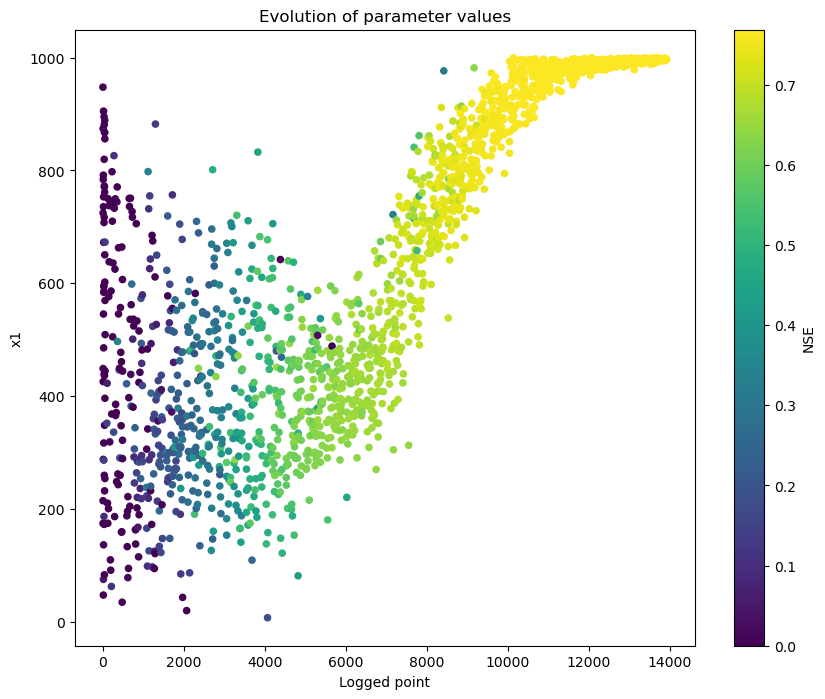

In [64]:
g = v.parameter_evolution(p_var_ids[0], obj_lims=[0,1])
plt.gcf().set_size_inches(10,8);

Note that the parameter x4 also seems to have settled at its lower bound:

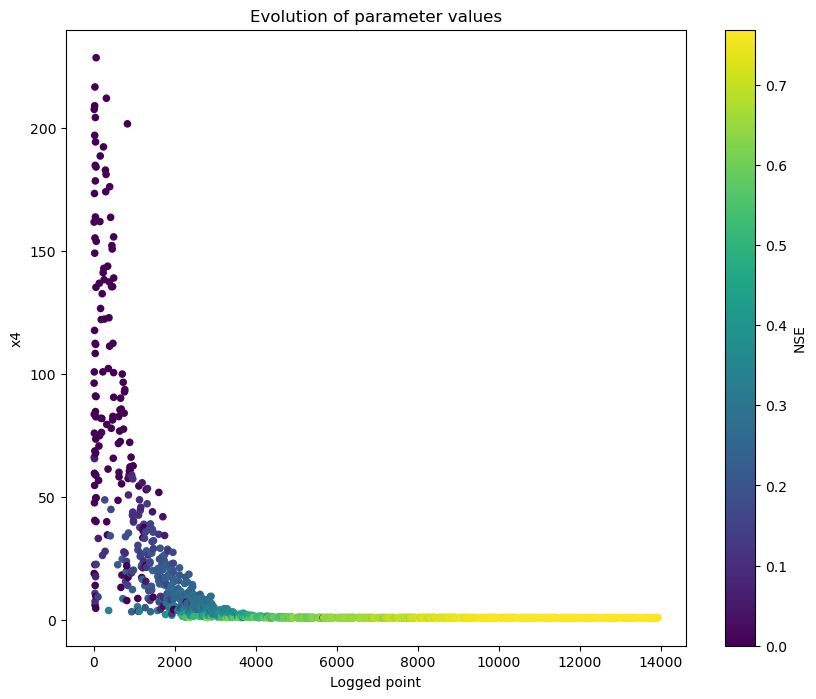

In [65]:
v.parameter_evolution(p_var_ids[3], obj_lims=[0,1])
plt.gcf().set_size_inches(10,8);

x4 influences the unit hydrograph, and the meaning of this parameter depends on the time step of the input series. It may be justified in this case to go below 1 for its lower bound. Also, the default maximum value 240 is typically sensible for use with hourly data, not daily, so we may want to reduce this maximum. 

So let's restart the calibration, with a larger upper bound for the x1 parameter, and adjusted x4 bounds as well:

In [66]:
pspec_gr4j.Max = [2500, 30, 1000, 10]
pspec_gr4j.Min = [1,-30, 1,0.2]

In [67]:
p = create_parameteriser('Generic', pspec_gr4j)
urs = create_parameter_sampler(0, p, 'urs')
optimiser = objective.create_sce_optim_swift(term, sce_params, urs)
calib_logger = optimiser.set_calibration_logger('')
calib_results = optimiser.execute_optimisation()
opt_log = optimiser.extract_optimisation_log(fitness_name = "NSE")

In [68]:
geom_ops = opt_log.subset_by_message(pattern= 'Initial.*|Reflec.*|Contrac.*|Add.*') # same as default argument, but to be explicit

In [69]:
p_var_ids = ['x1','x2','x3','x4']
remap = {f'subarea.Subarea.{name}': name for name in p_var_ids}
geom_ops.rename_columns(remap)

Let's check that the parameter does not settle at the boundary anymore:

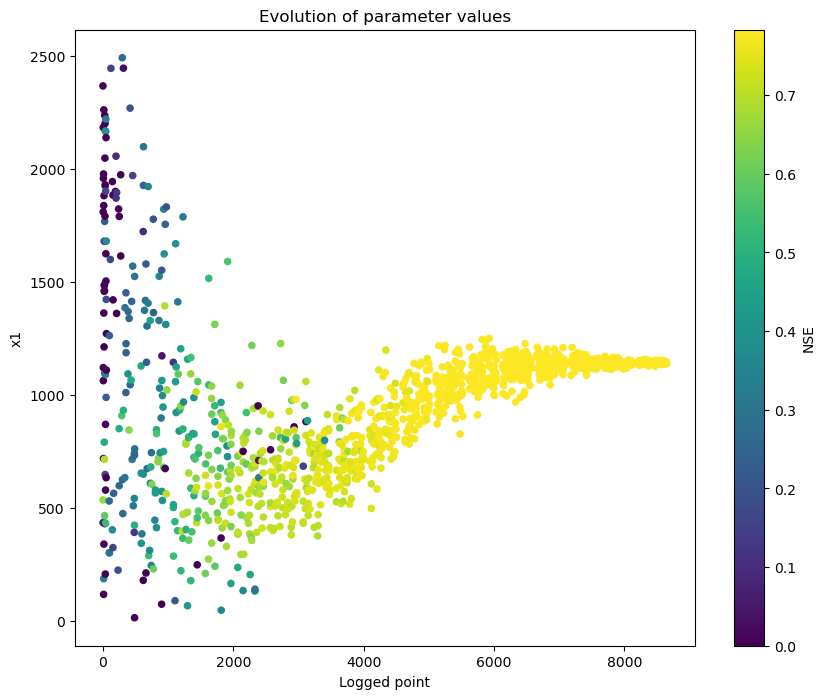

In [70]:
v = OptimisationPlots(geom_ops)
g = v.parameter_evolution(p_var_ids[0], obj_lims=[0,1])
plt.gcf().set_size_inches(10,8);

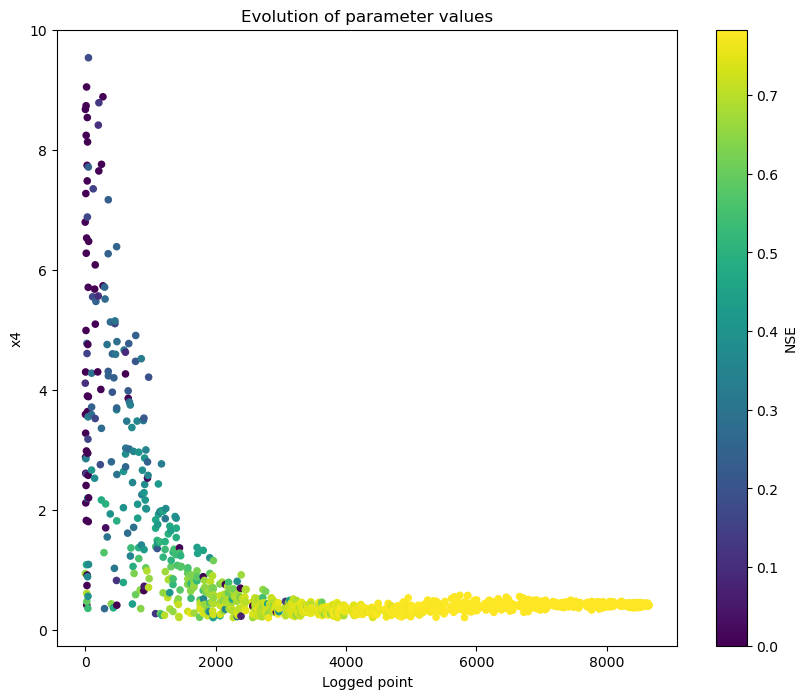

In [71]:
v.parameter_evolution(p_var_ids[3], obj_lims=[0,1])
plt.gcf().set_size_inches(10,8);

_Note_: There are a few additional visualisation options in the R package [**mhplot**](https://github.com/csiro-hydroinformatics/mhplot) that may be ported to python as needed.

We can inspect further the behavior of the SCE optimiser by using facetted plots with the package **seaborn**.

In [72]:
df = geom_ops.data

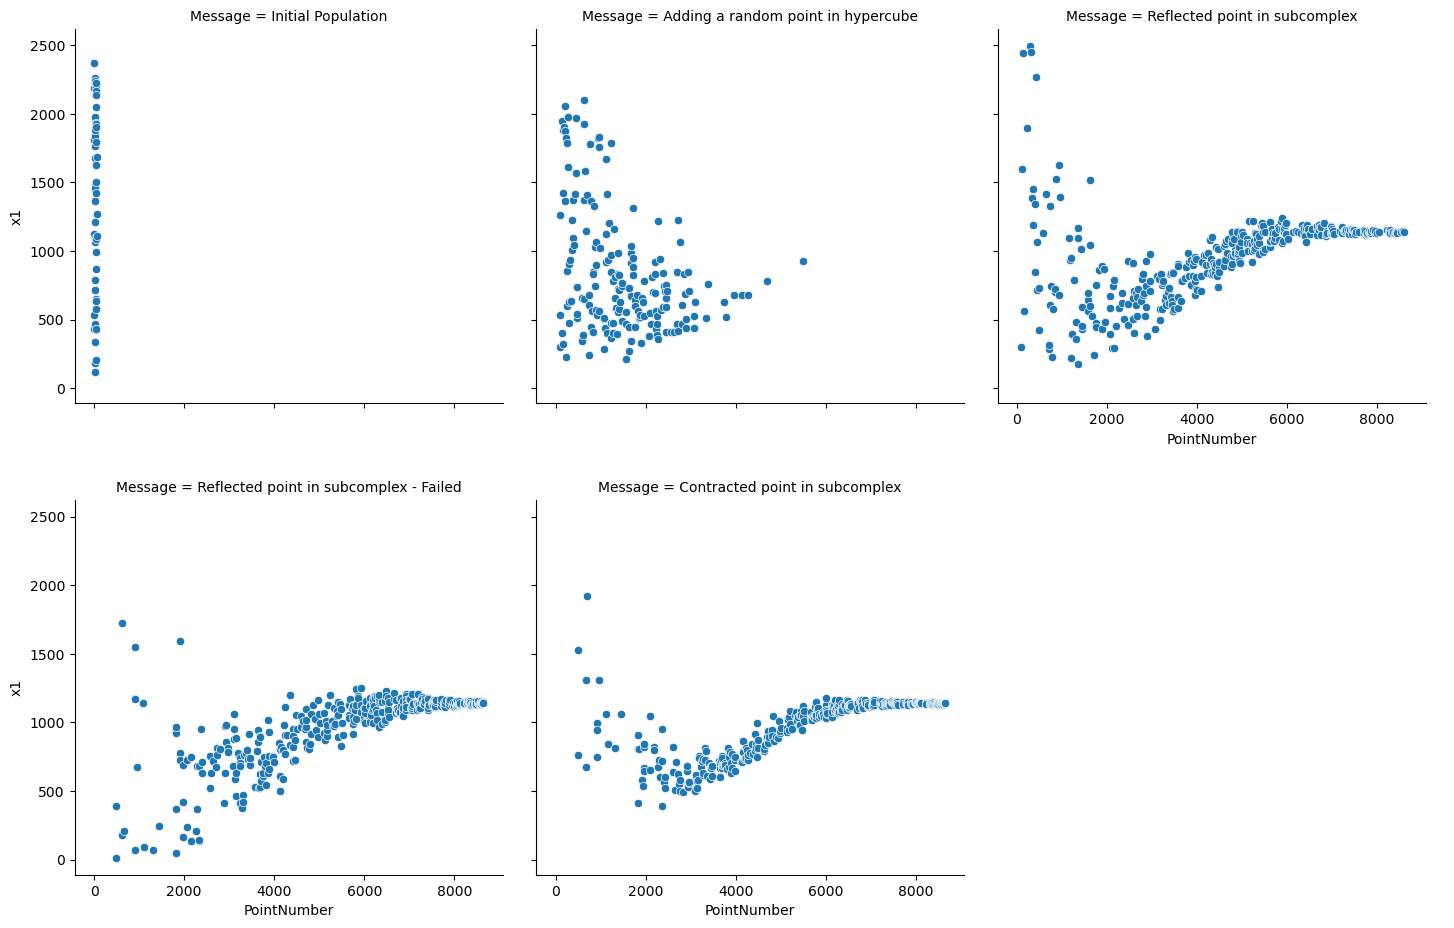

In [73]:
grid = geom_ops.facet_plot(p_var_ids[0])

Let's retrieve the parameter set with the best NSE, and see the resulting runoff time series. `calib_results` is a native C++ object, but its wrapper has functions to query it and extract the information wanted.


`calib_results` is the final population of parameter sets. To get the best score within it (i.e. the best fitness and associated parameters), we can use: 

In [74]:
best_pset = calib_results.get_best_score('NSE')

In [75]:
best_pset

CFFI pointer handle to a native pointer of type id "OBJECTIVE_SCORES_WILA_PTR"

Scores:

{'NSE': 0.7832225081975563}

Parameters:

                 Name        Value   Min     Max
0  subarea.Subarea.x1  1141.419555   1.0  2500.0
1  subarea.Subarea.x2    -5.448833 -30.0    30.0
2  subarea.Subarea.x3    97.579250   1.0  1000.0
3  subarea.Subarea.x4     0.414422   0.2    10.0

In [76]:
opt_log.data.tail()

,Category,CurrentShuffle,Message,NSE,subarea.Subarea.x1,subarea.Subarea.x2,subarea.Subarea.x3,subarea.Subarea.x4,PointNumber
8697,Shuffling No 17,,Shuffling No 17,0.783221,1136.271566,-5.462186,97.798741,0.425679,8698
8698,Shuffling No 17,,Shuffling No 17,0.783220,1140.838174,-5.423250,97.721428,0.397216,8699
8699,Shuffling No 17,,Shuffling No 17,0.783218,1138.591759,-5.473618,98.148408,0.418075,8700
8700,Shuffling No 17,,Shuffling No 17,0.783215,1151.965067,-5.400726,96.862435,0.463490,8701
8701,Shuffling No 17,,Best point in shuffle,0.783223,1141.419555,-5.448833,97.579250,0.414422,8702


## Time series visualisation

Let's apply this parameter to the original simulation, and execute it to get output runoff.

Note, as an aside, that below for didactic purposes we see only the last 3 years of time series, while the NSE score is calculated over several more years. As it happens, the runoff prediction has a systematic negative bias over these three particular years.


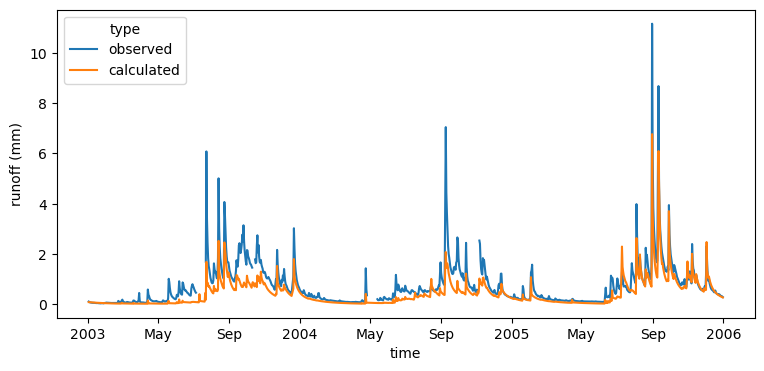

In [77]:
best_pset.apply_sys_config(ms)
ms.exec_simulation()
plot_obs_vs_calc(obs_runoff, ms.get_recorded(runoff_id).squeeze(drop=True))
plt.show()

Looking at the whole series over the simulation, indeed these last three years appear untypical in terms of match between observed and calculated

In [78]:
from swift2.vis import plot_two_series

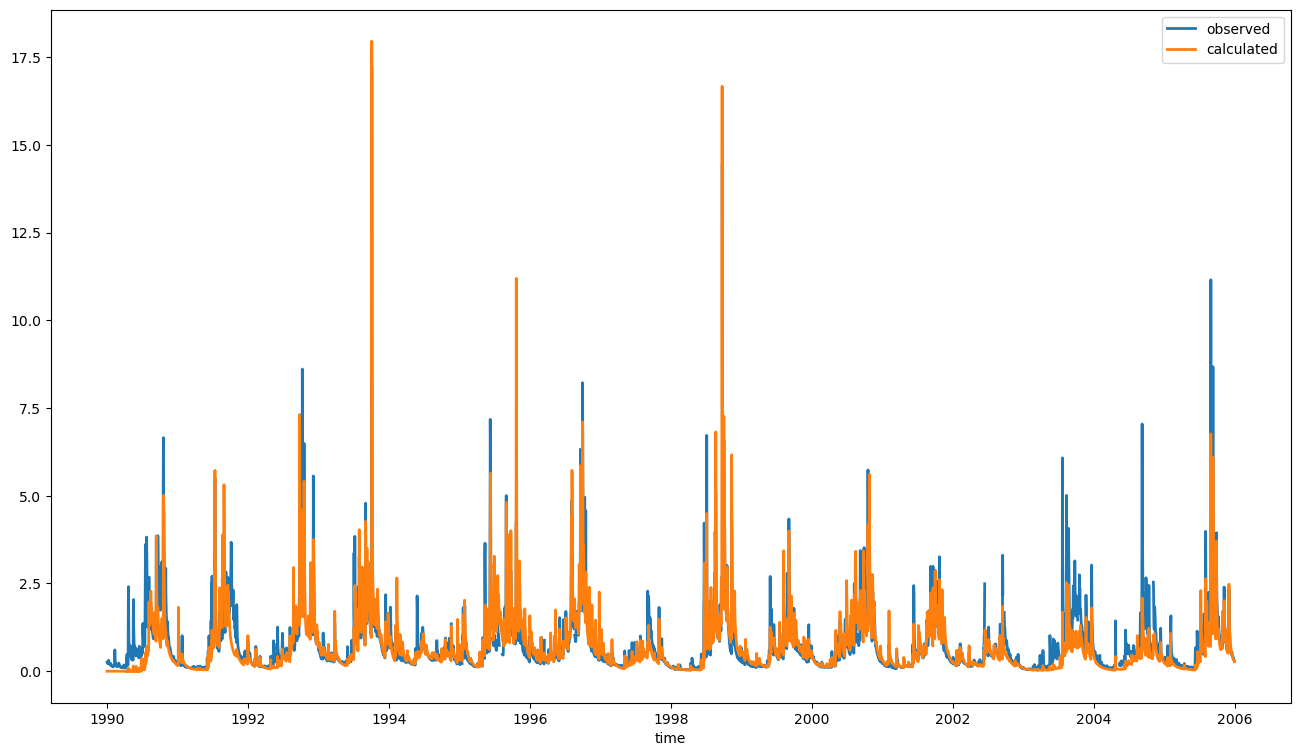

In [79]:
plot_two_series(obs_runoff, ms.get_recorded(runoff_id).squeeze(drop=True), names = ['observed','calculated'])